$$
\begin{align*}
\text{1D Heat Diffusion: }
\frac{du(x,t)}{dt} &= \alpha \frac{d^2u(x,t)}{dx^2} + f(x,t)
\end{align*}
$$


In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy.kern import RBF
from jax import grad

In [2]:
np.random.seed(123)

In [3]:
# Define parameters
L = 1.0 
N = 50  
alpha = 0.01  
T_final = 10.0  
dt = 0.1

# # Generate mesh grid
x = np.linspace(0, L, N) 


In [4]:
# Generate source terms 
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.2) #variance and lengthscale = 0.2, could implement parameter tuning 
gp = GPy.models.GPRegression(np.zeros((1,1)), np.zeros((1,1)), kernel)

f_source = gp.posterior_samples_f(x.reshape(-1, 1), full_cov=True, size=1) # generate only one source function 
f_source = f_source[:, 0, 0]

In [5]:
# Define initial condition 40th - 60th percentile = 1 
def initial_condition(N):
    """
    Define the initial temperature distribution along the rod.
    """
    u_init = jnp.zeros(N)
    start_index = int(0.4 * N)
    end_index = int(0.6 * N)
    u_init = u_init.at[start_index:end_index].set(1.0) 
    return u_init

u_init = initial_condition(N)

In [6]:
def heat_equation(u, f):

    d2u_dx2 = jnp.zeros_like(u)
    for i in range(len(u)):
        d2u_dx2 = d2u_dx2.at[i].set(grad(grad(lambda x: x))(u[i]))
    
        du_dt = alpha * d2u_dx2 + f

    return du_dt

In [7]:
# Perform time integration to solve the 1D heat diffusion equation using forward Euler's method 

def integrate(u):
    t_list = [0.0]
    t = 0.0
    while t < T_final:
        # Compute the temperature gradient
        du_dt = heat_equation(u, f_source)
        # Update the temperature using forward Euler's method
        u += dt * du_dt 
        # Increment time
        t += dt
        
        t_list.append(t)
    return u, t_list


In [8]:
u_final, t_values = integrate(u_init)
u_final

Array([ 2.5187507 ,  3.039222  ,  3.290033  ,  3.2533178 ,  2.9335802 ,
        2.357437  ,  1.571716  ,  0.63984257, -0.36319384, -1.3569245 ,
       -2.2619221 , -3.0061157 , -3.5303304 , -3.7924283 , -3.7698455 ,
       -3.4601195 , -2.87964   , -2.0607028 , -1.0472556 ,  0.11017854,
        2.3598855 ,  3.6540513 ,  4.952955  ,  6.2279725 ,  7.462752  ,
        8.652756  ,  9.803075  , 10.924824  , 12.0307    , 13.130509  ,
       13.226809  , 14.311878  , 15.3661785 , 16.358019  , 17.245401  ,
       17.978607  , 18.50393   , 18.767591  , 18.719685  , 18.317513  ,
       17.5286    , 16.332668  , 14.72328   , 12.709015  , 10.313969  ,
        7.5782084 ,  4.557583  ,  1.3230184 , -2.041029  , -5.4390163 ],      dtype=float32)

In [9]:
f_source

array([ 0.24938138,  0.30091344,  0.3257456 ,  0.32211072,  0.29045366,
        0.23340972,  0.1556153 ,  0.06335069, -0.03595981, -0.13434908,
       -0.22395266, -0.29763529, -0.34953725, -0.37548829, -0.37325245,
       -0.34258633, -0.28511299, -0.20402976, -0.1036886 ,  0.01090876,
        0.13464218,  0.26277671,  0.39138177,  0.51762057,  0.63987576,
        0.75769868,  0.87159166,  0.98265498,  1.09214968,  1.20104089,
        1.30958428,  1.41701925,  1.52140243,  1.61960527,  1.70746473,
        1.78006006,  1.83207238,  1.85817799,  1.85343309,  1.81361588,
        1.73550502,  1.61709499,  1.45775166,  1.2583188 ,  1.02118552,
        0.75031817,  0.45124629,  0.13099188, -0.20208184, -0.53851713])

In [10]:
# Add noise  N(0, λ_U^2 I) is the measurement noise with standard deviation λ_U > 0

def generate_noise(u, lambda_u):
    noise_u = np.random.normal(0, lambda_u**2, size = u.shape)
    u_noise = u + noise_u
    return u_noise

In [11]:
lambda_u = 0.1

u_noisy = generate_noise(u_final, lambda_u)

In [12]:
training_data = np.concatenate((u_noisy[:, np.newaxis], f_source[:, np.newaxis]), axis=1)
training_data

array([[ 2.50580978e+00,  2.49381378e-01],
       [ 3.02883410e+00,  3.00913441e-01],
       [ 3.30747032e+00,  3.25745605e-01],
       [ 3.24533725e+00,  3.22110718e-01],
       [ 2.93387699e+00,  2.90453659e-01],
       [ 2.36812997e+00,  2.33409720e-01],
       [ 1.58062303e+00,  1.55615298e-01],
       [ 6.57391429e-01,  6.33506922e-02],
       [-3.48237395e-01, -3.59598061e-02],
       [-1.34623063e+00, -1.34349082e-01],
       [-2.26964927e+00, -2.23952661e-01],
       [-2.99816704e+00, -2.97635290e-01],
       [-3.52718759e+00, -3.49537249e-01],
       [-3.80569100e+00, -3.75488290e-01],
       [-3.75567245e+00, -3.73252447e-01],
       [-3.45204711e+00, -3.42586331e-01],
       [-2.87918520e+00, -2.85112991e-01],
       [-2.06303382e+00, -2.04029764e-01],
       [-1.05923867e+00, -1.03688598e-01],
       [ 1.12173781e-01,  1.09087622e-02],
       [ 2.36456990e+00,  1.34642180e-01],
       [ 3.64573979e+00,  2.62776706e-01],
       [ 4.96457672e+00,  3.91381770e-01],
       [ 6.

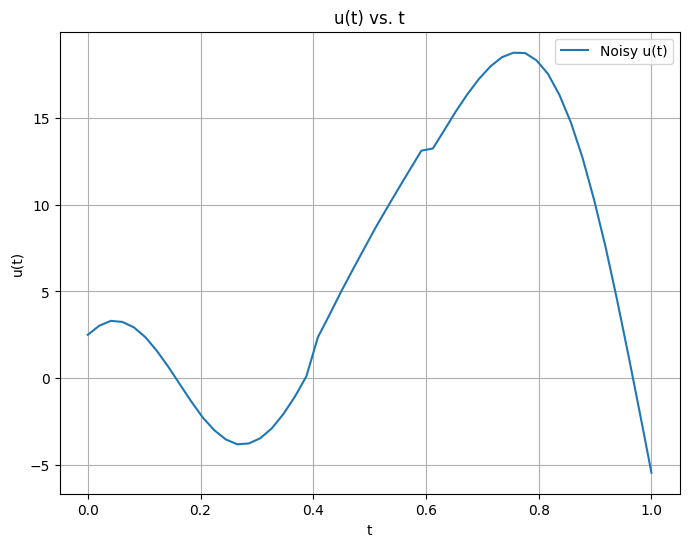

In [13]:
# Unsmoothed u(t)

t_values = np.linspace(0, 1, N)

plt.figure(figsize=(8, 6))
plt.plot(t_values, u_noisy, label='Noisy u(t)')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('u(t) vs. t')
plt.grid(True)
plt.legend()
plt.show()


Step (i): 
kernel smoothing is utilized to denoise the training data 
and use kernel regression to compute pertinent partial derivatives of the solution

$\hat{u}^{(i)}(x) = U(x, X) (U(X, X) + \lambda^2_U I)^{-1} u^{(i)}$

$\partial^{\alpha_j}\hat{u}^{(i)}(x) = \partial^{\alpha_j} U(x, X) (U(X, X) + \lambda^2_U I)^{-1} u^{(i)} $


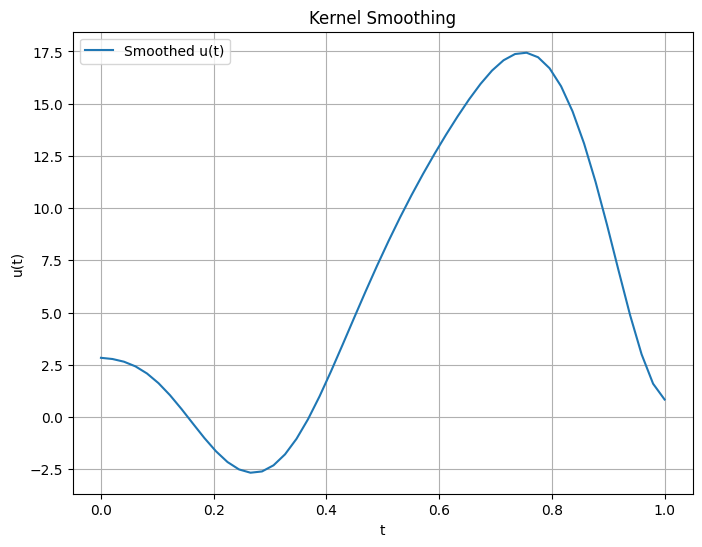

In [14]:
# smoothed out u(t) using the kernel 

from scipy.ndimage import gaussian_filter1d

smoothed_u = gaussian_filter1d(u_noisy, sigma=3)  # parameter tunign for sigma 

plt.figure(figsize=(8, 6))
plt.plot(x, smoothed_u, label='Smoothed u(t)')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Kernel Smoothing')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# Kernel Regression

# Define a kernel for regression
kernel_regression = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.2)

# Fit a Gaussian process regression model to estimate the first derivative
gp_regression = GPy.models.GPRegression(x.reshape(-1, 1), smoothed_u.reshape(-1, 1), kernel_regression)
gp_regression.optimize()  # Optimize hyperparameters if needed

# first derivative 
u_prime = gp_regression.predictive_gradients(x.reshape(-1, 1))[0]
u_prime = u_prime.squeeze()

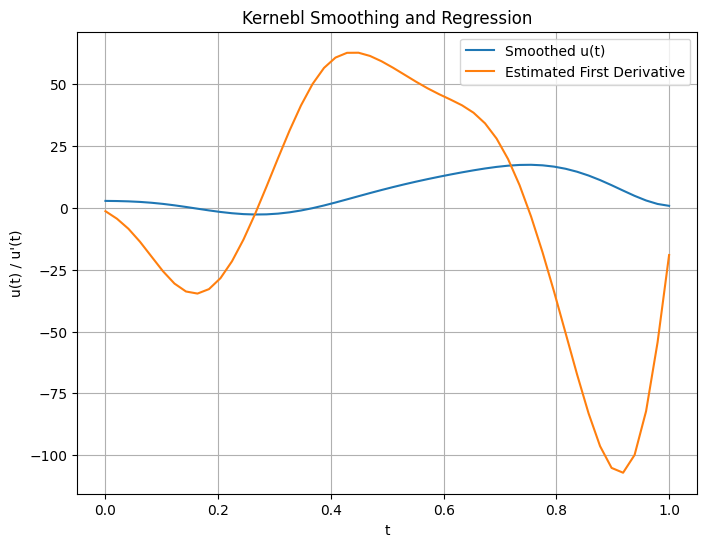

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(x, smoothed_u, label='Smoothed u(t)')
plt.plot(x, u_prime, label='Estimated First Derivative')
plt.xlabel('t')
plt.ylabel('u(t) / u\'(t)')
plt.title('Kernebl Smoothing and Regression')
plt.grid(True)
plt.legend()
plt.show()